## Part 2: Clinical Application

### Contents
Fill out this notebook as part 2 of your final project submission.

**You will have to complete the Code (Load Metadata & Compute Resting Heart Rate) and Project Write-up sections.**  

- [Code](#Code) is where you will implement some parts of the **pulse rate algorithm** you created and tested in Part 1 and already includes the starter code.
  - [Imports](#Imports) - These are the imports needed for Part 2 of the final project. 
    - [glob](https://docs.python.org/3/library/glob.html)
    - [os](https://docs.python.org/3/library/os.html)
    - [numpy](https://numpy.org/)
    - [pandas](https://pandas.pydata.org/)
  - [Load the Dataset](#Load-the-dataset)  
  - [Load Metadata](#Load-Metadata)
  - [Compute Resting Heart Rate](#Compute-Resting-Heart-Rate)
  - [Plot Resting Heart Rate vs. Age Group](#Plot-Resting-Heart-Rate-vs.-Age-Group)
- [Project Write-up](#Project-Write-Up) to describe the clinical significance you observe from the **pulse rate algorithm** applied to this dataset, what ways/information that could improve your results, and if we validated a trend known in the science community. 

### Dataset (CAST)

The data from this project comes from the [Cardiac Arrythmia Suppression Trial (CAST)](https://physionet.org/content/crisdb/1.0.0/), which was sponsored by the National Heart, Lung, and Blood Institute (NHLBI). CAST collected 24 hours of heart rate data from ECGs from people who have had a myocardial infarction (MI) within the past two years.[1] This data has been smoothed and resampled to more closely resemble PPG-derived pulse rate data from a wrist wearable.[2]

1. **CAST RR Interval Sub-Study Database Citation** - Stein PK, Domitrovich PP, Kleiger RE, Schechtman KB, Rottman JN. Clinical and demographic determinants of heart rate variability in patients post myocardial infarction: insights from the Cardiac Arrhythmia Suppression Trial (CAST). Clin Cardiol 23(3):187-94; 2000 (Mar)
2. **Physionet Citation** - Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals (2003). Circulation. 101(23):e215-e220.

-----

### Code
#### Imports

When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages are imported for you here. We recommend you don't import other packages outside of the [Standard Library](https://docs.python.org/3/library/) , otherwise the grader might not be able to run your code.

In [21]:
import glob
import os

import numpy as np
import pandas as pd

# Pallets used for visualizations
from matplotlib.colors import ListedColormap

color= "Spectral"
color_plt = ListedColormap(sns.color_palette(color).as_hex())
color_hist = 'teal'
two_colors = [ sns.color_palette(color)[0], sns.color_palette(color)[5]]
three_colors = [ sns.color_palette(color)[5],sns.color_palette(color)[2], sns.color_palette(color)[0]]
BOLD = '\033[1m'
END = '\033[0m'

In [62]:
#import sys 
#!{sys.executable} -m pip install seaborn==0.9.0

#### Load the dataset

The dataset is stored as [.npz](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html) files. Each file contains roughly 24 hours of heart rate data in the 'hr' array sampled at 1Hz. The subject ID is the name of the file. You will use these files to compute resting heart rate.

Demographics metadata is stored in a file called 'metadata.csv'. This CSV has three columns, one for subject ID, age group, and sex. You will use this file to make the association between resting heart rate and age group for each gender.

Find the dataset in `../datasets/crisdb/`

In [2]:
hr_filenames = glob.glob('/data/crisdb/*.npz')

In [3]:
hr_filenames[0]

'/data/crisdb/e190a.npz'

#### Load Metadata
Load the metadata file into a datastructure that allows for easy lookups from subject ID to age group and sex.

In [4]:
metadata_filename = '/data/crisdb/metadata.csv'

# Load the metadata file into this variable.
with open(metadata_filename, 'r') as f:
    metadata = pd.read_csv(f)

In [5]:
metadata.head()

,subject,age,sex
0,e198a,20-24,Male
1,e198b,20-24,Male
2,e028b,30-34,Male
3,e028a,30-34,Male
4,e061b,30-34,Male


#### Compute Resting Heart Rate
For each subject we want to compute the resting heart rate while keeping track of which age group this subject belongs to. An easy, robust way to compute the resting heart rate is to use the lowest 5th percentile value in the heart rate timeseries.

In [6]:
def AgeAndRHR(metadata, filename):

    # Load the heart rate timeseries
    hr_data = np.load(filename)['hr']
    
    # Compute the resting heart rate from the timeseries by finding the lowest 5th percentile value in hr_data
    rhr = np.percentile(hr_data, 5)
    
    # Find the subject ID from the filename.
    subject = filename.split('/')[-1].split(".")[0]

    # Find the age group for this subject in metadata.
    age_group = metadata[metadata['subject']==subject]['age'].values[0]
    
    # Find the sex for this subject in metadata.
    sex = metadata[metadata['subject']==subject]['sex'].values[0]

    return age_group, sex, rhr

df = pd.DataFrame(data=[AgeAndRHR(metadata, filename) for filename in hr_filenames],
                  columns=['age_group', 'sex', 'rhr'])

In [7]:
df.head()

,age_group,sex,rhr
0,60-64,Female,89.302326
1,65-69,Male,65.641026
2,45-49,Male,56.928458
3,60-64,Male,68.571429
4,50-54,Male,84.395604


#### Plot Resting Heart Rate vs. Age Group
We'll use [seaborn](https://seaborn.pydata.org/) to plot the relationship. Seaborn is a thin wrapper around matplotlib, which we've used extensively in this class, that enables higher-level statistical plots.

We will use [lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot) to plot the mean of the resting heart rates for each age group along with the 95% confidence interval around the mean. Learn more about making plots that show uncertainty [here](https://seaborn.pydata.org/tutorial/relational.html#aggregation-and-representing-uncertainty).

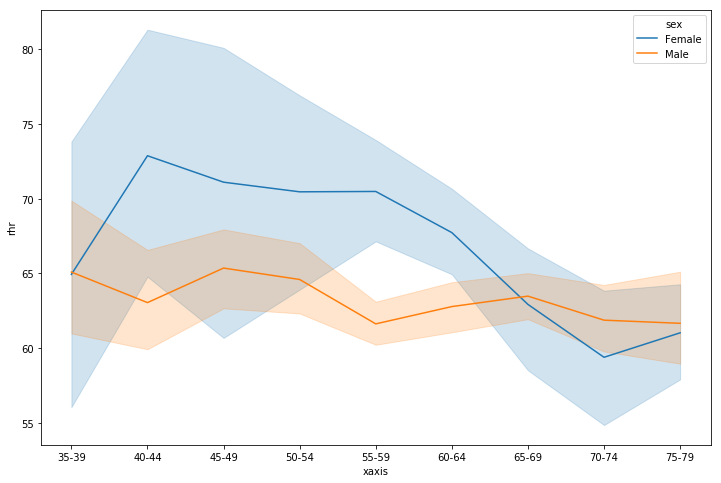

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt

labels = sorted(np.unique(df.age_group))
df['xaxis'] = df.age_group.map(lambda x: labels.index(x)).astype('float')
plt.figure(figsize=(12, 8))

sns.lineplot(x='xaxis', y='rhr', hue='sex', data=df)
_ = plt.xticks(np.arange(len(labels)), labels)

### Clinical Conclusion
Answer the following prompts to draw a conclusion about the data.
> 1. For women, we see .... 
> 2. For men, we see ... 
> 3. In comparison to men, women's heart rate is .... 
> 4. What are some possible reasons for what we see in our data?
> 5. What else can we do or go and find to figure out what is really happening? How would that improve the results?
> 6. Did we validate the trend that average resting heart rate increases up until middle age and then decreases into old age? How?

Your write-up will go here...

### Student Answers:
1. For women, we see they only account for 18% of the dataset. Women's heart rates are the highest in the age group 45-49 with an median of 73.4 and SD 19, and the age group that has the lowest median are the oldest age group. Also women's heart rate have more variance within age groups. especially within the age groups of 45-49 and 65-69. Meaning that there is high uncertainty in women's heart rate.


2. For men, we see that they account for 82% of the dataset. The variance in men's heart rate is more consistent along the years. Which means that there is less uncertainty than men's heart rate is around 63 BPM. 


3. In comparison to men, women's heart rate is  higher and have a higher variance.


4. **What are some possible reasons for what we see in our data?**

This might be happening because of the smaller sample of female compared to males are the females are only 18% of the dataset whereas the males are arund 82%.


5. **What else can we do or go and find to figure out what is really happening? How would that improve the results?**

To improve the results, we must have an even number of samples for men and women in the dataset. Otherwise, the analysis will be more accurate for men than women because of the big sample size.

6. **Did we validate the trend that average resting heart rate increases up until middle age and then decreases into old age? How?**

No, there is no evidence of that. The trend can be seen in the age groups of females and heart rate plot, however we cannot validate that because of the very small sample that we have.  

### Analysis and visualization 

The Distribution of Gender in all Patients: 
Male      0.819779
Female    0.180221
Name: sex, dtype: float64


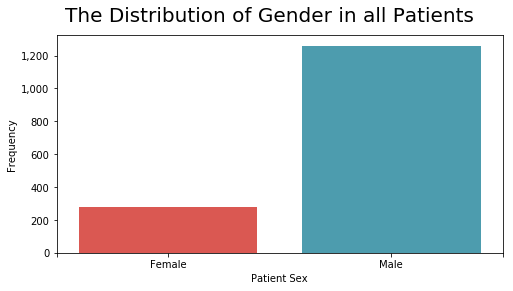

In [26]:
fig, ax = plt.subplots( figsize=(8, 4))
sns.countplot(x='sex',orient='h', data= df, palette = two_colors, saturation=0.90)

ax.set_xlabel('Patient Sex')
ax.set_ylabel('Frequency')
plt.xticks([-0.5, 0, 1, 1.5], ['', 'Female','Male',''])
fig.suptitle('The Distribution of Gender in all Patients ', fontsize = 20)

ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

print(BOLD+'The Distribution of Gender in all Patients:',END)
print(df['sex'].value_counts()/len(df))

plt.show();

In [58]:
print(BOLD+'The Distribution of age group in all Patients:',END)
print(df['age_group'].value_counts()/len(df))

The Distribution of age group in all Patients: 
60-64    0.203643
65-69    0.189330
55-59    0.169811
70-74    0.127521
50-54    0.106701
45-49    0.080677
75-79    0.063761
40-44    0.040338
35-39    0.018217
Name: age_group, dtype: float64


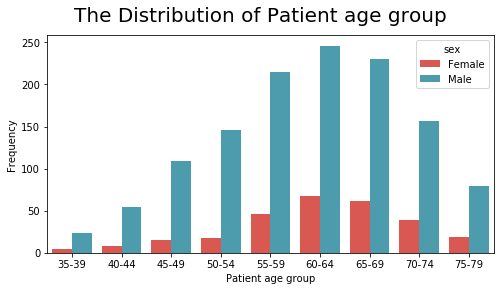

In [59]:
fig, ax = plt.subplots( figsize=(8, 4))
sns.countplot(x='age_group',orient='h', data= df, hue= 'sex',
              order=['35-39','40-44', '45-49','50-54', '55-59','60-64', '65-69', '70-74','75-79'],
              palette = two_colors, saturation=0.90)

ax.set_xlabel('Patient age group')
ax.set_ylabel('Frequency')
fig.suptitle('The Distribution of Patient age group ', fontsize = 20)


plt.show();

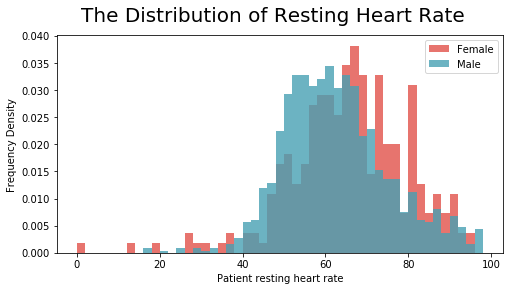

In [32]:
fig, ax = plt.subplots( figsize=(8, 4))
ax.hist(df[df['sex']=='Female']['rhr'], bins=np.arange(0,100,2), alpha=0.8, color=sns.color_palette(color)[0], density= True, label = 'Female')
ax.hist(df[df['sex']=='Male']['rhr'], bins=np.arange(0,100,2), alpha=0.8, color=sns.color_palette(color)[5], density= True, label = 'Male')

ax.set_xlabel('Patient resting heart rate')
ax.set_ylabel('Frequency Density')
plt.legend(loc='best')
fig.suptitle('The Distribution of Resting Heart Rate', fontsize = 20)

plt.show();

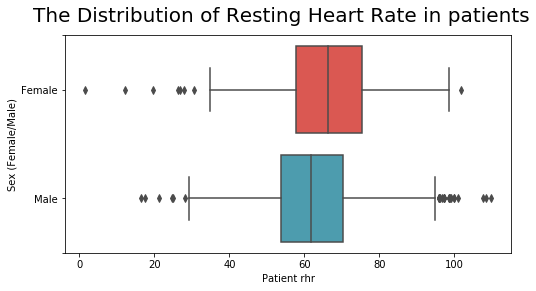

In [33]:
fig, ax = plt.subplots( figsize=(8, 4))
sns.boxplot(x='rhr', y='sex',orient='h', data= df, palette = two_colors, saturation=0.90)

ax.set_xlabel('Patient rhr')
plt.yticks([-0.5, 0, 1, 1.5], ['','Female', 'Male',''])
plt.xticks(np.arange(0,120,20))
ax.set_ylabel('Sex (Female/Male)')
fig.suptitle('The Distribution of Resting Heart Rate in patients', fontsize = 20)

plt.show();

In [49]:
df[df['sex']=='Female'][['rhr']].describe().T

,count,mean,std,min,25%,50%,75%,max
rhr,277.0,65.965632,14.393868,1.55887,57.744361,66.300003,75.247986,101.726316


In [15]:
df[df['sex']=='Male'][['rhr']].describe().T

,count,mean,std,min,25%,50%,75%,max
rhr,1260.0,63.016196,13.064686,16.365223,53.782763,61.687742,70.369667,109.714286


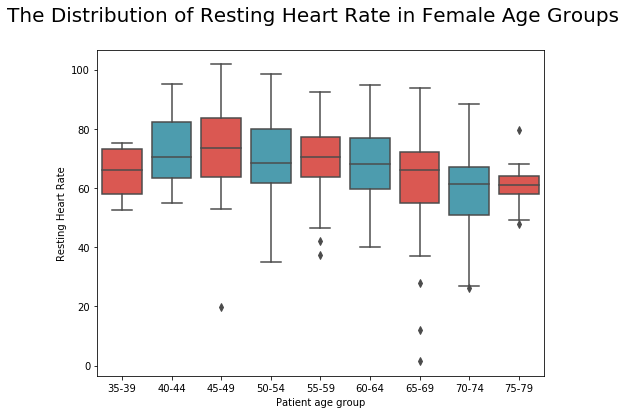

In [60]:
fig, ax = plt.subplots( figsize=(8, 6))
sns.boxplot(x='age_group', y='rhr',orient=None, data= df[df['sex']=='Female'], 
            order=['35-39','40-44', '45-49','50-54', '55-59','60-64', '65-69', '70-74','75-79'],
            palette = two_colors, saturation=0.90)

ax.set_xlabel('Patient age group')

ax.set_ylabel('Resting Heart Rate')
fig.suptitle('The Distribution of Resting Heart Rate in Female Age Groups', fontsize = 20)

plt.show();

In [51]:
df[df['sex']=='Female'].groupby('age_group')[['rhr']].describe()

rhr                                                         \
          count       mean        std        min        25%        50%   
age_group                                                                
35-39       4.0  64.936157  10.743882  52.409348  57.866017  66.068868   
40-44       8.0  72.880497  13.096411  55.037016  63.419024  70.512129   
45-49      15.0  71.109613  19.509168  19.729796  63.790653  73.400829   
50-54      18.0  70.464430  14.508093  34.947863  61.514561  68.339129   
55-59      46.0  70.488809  12.522566  37.289038  63.572916  70.464646   
60-64      67.0  67.733858  12.379561  40.120687  59.647670  67.964602   
65-69      61.0  62.926454  16.042538   1.558870  55.054471  66.206897   
70-74      39.0  59.386176  14.732023  26.203684  50.811667  61.440000   
75-79      19.0  61.024178   6.889330  47.859866  57.969694  60.952381   

                                  
                 75%         max  
age_group                         
35-39      73.139009   75.197544  
40-44      82.146161   95.068365  
45-49      83.749407  101.726316  
50-54      80.000000   98.461538  
55-59      77.096008   92.530120  
60-64      76.862082   94.814815  
65-69      72.180408   93.658537  
70-74      66.931587   88.275862  
75-79      64.141177   79.587629

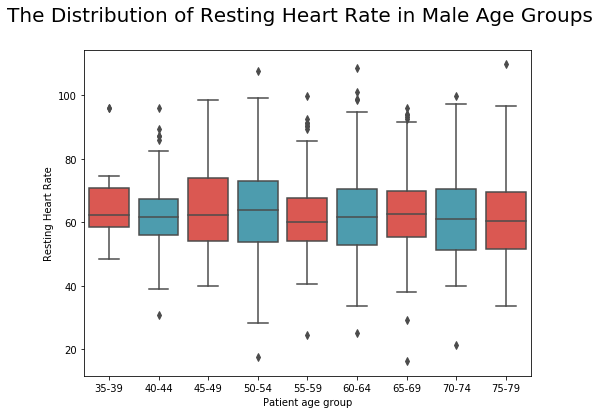

In [61]:
fig, ax = plt.subplots( figsize=(8, 6))
sns.boxplot(x='age_group', y='rhr',orient=None, data= df[df['sex']=='Male'], 
            order=['35-39','40-44', '45-49','50-54', '55-59','60-64', '65-69', '70-74','75-79'],
            palette = two_colors, saturation=0.90)

ax.set_xlabel('Patient age group')

ax.set_ylabel('Resting Heart Rate')
fig.suptitle('The Distribution of Resting Heart Rate in Male Age Groups', fontsize = 20)

plt.show();

In [53]:
df[df['sex']=='Male'].groupby('age_group')[['rhr']].describe()

rhr                                                         \
           count       mean        std        min        25%        50%   
age_group                                                                 
35-39       24.0  65.092105  11.897925  48.609542  58.570437  62.451896   
40-44       54.0  63.046920  12.343532  30.727668  55.955692  61.747190   
45-49      109.0  65.359438  14.383833  40.106899  54.276296  62.293042   
50-54      146.0  64.594842  14.592072  17.603231  53.897400  63.981300   
55-59      215.0  61.622980  10.915386  24.698375  54.166624  60.000000   
60-64      246.0  62.780684  13.288616  25.111180  52.784128  61.658469   
65-69      230.0  63.480979  12.179729  16.365223  55.464798  62.566973   
70-74      157.0  61.871341  14.167787  21.346593  51.233249  60.952381   
75-79       79.0  61.661049  13.587539  33.568408  51.553910  60.472441   

                                  
                 75%         max  
age_group                         
35-39      70.717044   96.000000  
40-44      67.383708   96.000000  
45-49      73.846154   98.461538  
50-54      73.056604  107.671758  
55-59      67.779115   99.740260  
60-64      70.458716  108.462833  
65-69      69.996050   96.000000  
70-74      70.496922   99.740260  
75-79      69.620271  109.714286